# Do CE events cross the lisa band?
Use the $\alpha\lambda$ energy conservation to connect pre- and
post-CE orbital separation.

In [22]:
import numpy as np
from astropy import units as u
from astropy import constants as const
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator #, FormatStrFormatter, FuncFormatter, MaxNLocator

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Mathieu's plots defaults -- these below is not strictly necessary
import sys
# see https://github.com/mathren90/plotFunc
sys.path.append('/home/math/Documents/Research/codes/plotFunc/')
# from plotDefaults import set_plotDefaults

In [2]:
# run this to set plot defaults
set_plotDefaults()

NameError: name 'set_plotDefaults' is not defined

# Calculating the final separations for theoretical RSGs

In [3]:
def Menv(Mc):
    """ given a He core mass, returns the envelope mass
        calculated as M_env = Mtot-Mcore. Data come from BSE """
    dataFile = "./core_masses.txt"
    F = open(dataFile,"r")
    for i, line in enumerate(F):
        if i==0:
            col = line.split()
            break
    F.close()
    data = np.genfromtxt(dataFile,skip_header=1)
    # filter MS longer than age of the Universe
    t_tams = data[:,col.index("MS_duration")]
    ind = t_tams < 13700
    Mass = data[ind, col.index("mass")]
    Mcore = data[ind, col.index("core_mass")]
    Mtot = np.interp(Mc,Mcore, Mass, left=0)
    Menv = Mtot - Mc
    #sanity check
    # fig, ax = plt.subplots(figsize=(12,10))
    # ax.plot(Mcore, M)
    # ax.set_xlabel(r"$M_\mathrm{He} \ [M_\odot]$", size=30)
    # ax.set_ylabel(r"$M_\mathrm{tot} \ [M_\odot]$", size=30)
    # ax.axvline(Mc)
    # ax.axhline(Mtot)    
    return Menv
# test
Menv(5) 

13.662520325203253

In [4]:
# define colormap
rainbow = plt.cm.Dark2(np.linspace(0.,1,8))

3.2944589982425305 solMass 36.44054955752214 solMass


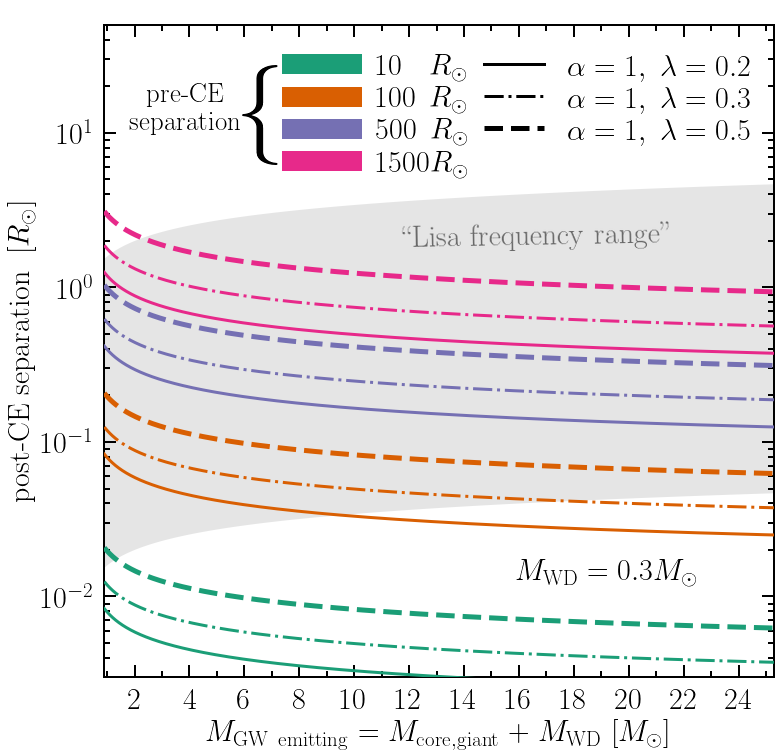

In [34]:
def Rrl(a, m1, m2):
    #RL1 for q = m1/m2
    q = m1/m2
    RL = a * 0.49 * q**(2./3) *(0.6 * q**(2./3) +np.log(1 + q**(1./3)) )**-1
    return RL
    
def aLISA(mass):
    min_freq = 1e-4 *u.s**-1
    mass = mass.to(u.kg)
    a = pow(const.G * mass * (np.pi * min_freq)**-2, 1./3. )
    return a.to(u.Rsun)

def aLISAexit(mass):
    min_freq = 1e-1 *u.s**-1
    mass = mass.to(u.kg)
    a = pow(const.G * mass * (np.pi * min_freq)**-2, 1./3. )
    return a.to(u.Rsun)

def afinal(Mdcore = 1*u.Msun, Mdenv= 1*u.Msun, Mcomp= 1*u.Msun, a_ent= 1*u.Rsun, alpha=1.0, Lambda= 0.2):
    ## Mathieu: based on Fig. 1 in de Marco et al. 2011, lambda=0.2-0.3 is more realistic.
    Mdon = Mdcore + Mdenv
    Rrld = Rrl(a_ent, Mdon, Mcomp)
    # print('Rrld', Rrld)
    afinal = (Mdcore*Mcomp)/2 * ( (Mdon*Mdenv)/(alpha*Lambda*Rrld) + (Mdon*Mcomp)/(2*a_ent) )**-1
    return afinal

def plot_afinal_Mgw(companion_mass = 0.3, alpha=1.0):
    #companion_mass The withe dwarf falling into the envelope

    fig, ax = plt.subplots(figsize=(12,12))
   
    core_masses = np.arange(0.6, 25, 0.01) #Donor core masses
    # Mathieu: for core mass less than 0.6 the envelope mass from BSE is negative (guess those stars live longer than the universe!)
    masses = core_masses + companion_mass

    donor_envelope_masses = Menv(core_masses)*u.Msun # core_masses *2*u.Msun   #ballpack estimate
    print(min(donor_envelope_masses), max(donor_envelope_masses))
    #Add units
    companion_mass = companion_mass*u.Msun 
    core_masses = core_masses*u.Msun
    masses = masses*u.Msun

    
    ##############################
    ## Plot final separation as a function of GW emitting mass
    a_enters = [10, 100, 500, 1500]#previous 10, 100, 200, 500, 1000 3000
    for i, a in enumerate(a_enters):
        # print(a)
        color = rainbow[i]
        ## alpha=1, Lambda=0.2
        afinals = afinal(Mdcore = core_masses, Mdenv = donor_envelope_masses, Mcomp= companion_mass, a_ent= a*u.Rsun, alpha=alpha, Lambda=0.2) 
        plt.plot(masses, afinals, # label = 'afinal, aent = '+str(a),
                 lw=3,c = color, zorder=10 )
        ## alpha=1, Lambda=0.3
        afinals = afinal(Mdcore = core_masses, Mdenv = donor_envelope_masses, Mcomp= companion_mass, a_ent= a*u.Rsun, alpha=alpha, Lambda=0.3) 
        plt.plot(masses, afinals, # label = 'afinal, aent = '+str(a),
                 ls='-.',lw=3, c = color, zorder=10 )
        ## alpha=1, Lambda=0.5
        afinals = afinal(Mdcore = core_masses, Mdenv = donor_envelope_masses, Mcomp= companion_mass, a_ent= a*u.Rsun, alpha=alpha, Lambda=0.5) 
        plt.plot(masses, afinals, # label = 'afinal, aent = '+str(a),
                 ls='--',lw=5, c = color, zorder=10 )
    ## for legend lines distinguishing lambda
    tabs = ['\phantom{00}','\phantom{0}', '\phantom{0}',"" ]
    for i, a in enumerate(a_enters):
        ax.plot(np.nan, np.nan, ls='-', lw=20, label=r"%.0f"%float(a)+tabs[i]+"$R_\odot$", c= rainbow[i])
    ax.plot(np.nan, np.nan, ls='-', c='k',lw=3, label=r"$\alpha=1,\ \lambda=0.2$")
    ax.plot(np.nan, np.nan, ls='-.',c='k',lw=3, label=r"$\alpha=1,\ \lambda=0.3$")
    ax.plot(np.nan, np.nan, ls='--',c='k',lw=5, label=r"$\alpha=1,\ \lambda=0.5$")
     
    ## Arrow showing example drop
#     point = 250
#     afin = afinal(Mdcore = core_masses[point], Mdenv = donor_envelope_masses[point], Mcomp= companion_mass, a_ent= 10*u.Rsun, alpha=alpha, Lambda=0.5) 
#     ax.annotate("", xy = (masses[point].value,afin.value ),  xytext = (masses[point].value, 10 ), color=rainbow[0],
#                 arrowprops=dict(facecolor=rainbow[0],color=rainbow[0]))
#     ax.annotate("", xy = (masses[point].value,afin.value ),  xytext = (masses[point].value, 10 ), color=rainbow[0],
#                 arrowprops=dict(facecolor=rainbow[0],edgecolor=rainbow[0],arrowstyle="|-|,widthA=0.75,widthB=0.",lw=5))
        
    ##################################
    ## Show region observable by LISA
    ax.fill_between(masses, aLISAexit(masses), aLISA(masses), facecolor='#808080',  alpha=0.2, zorder=0)
    plt.text(0.65, 0.675, r' ``Lisa frequency range"', fontsize = 30,color = '#696969', rotation=1,
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, zorder = 1)

    # WD mass
    plt.text(0.75, 0.16, r'$M_\mathrm{WD}='+str(companion_mass.value)+r'M_\odot$', fontsize = 30, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
    
    ##################################
    ## Plot values
    ## legend
#     ax.text(0.1,0.8725,r"$a_\mathrm{pre-CE}$", fontsize=30, va="center", ha="center", transform=ax.transAxes)#transform=ax.transData)
    ax.text(0.12,0.8725,"pre-CE \n separation", fontsize=27, va="center", ha="center", transform=ax.transAxes)#transform=ax.transData)
    ax.annotate(r"$\{$",fontsize=100,xy=(0.31, 0.815), xycoords='figure fraction')
    l = ax.legend(fontsize = 30, bbox_to_anchor=(0.24,1),  bbox_transform=ax.transAxes, loc="upper left", # loc = 'upper right',ax.transData
                  ncol=2, columnspacing=0.5, labelspacing=0.1)
    l.draw_frame(False)
    
    ## Limits
    ax.set_ylim(3e-3,50)#1e2)
    ax.set_xlim(min(masses.value), max(masses.value))   
    
    ## Labels and spines
    plt.xlabel(r'$M_\mathrm{GW\ emitting}$ = $M_\mathrm{core,giant}$ + $M_\mathrm{WD}$ [$M_\odot$]',size = 30)
#     plt.ylabel(r'$a_\mathrm{post-CE}\ [R_\odot]$',size = 30)
    plt.ylabel(r'post-CE separation $\ [R_\odot]$',size = 30)
    plt.tick_params(axis='both', which='major', labelsize=25) #right side
    plt.yscale('log')
    
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
    ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    ## annotate the effect of changing $\alpha$    
    # plt.savefig('many_lambdas'+str(companion_mass.value).replace('.', 'd')+'.pdf', bbox_inches='tight')
    # plt.savefig('alphaLambda_separation.pdf', bbox_inches='tight')
    plt.show()
    

plot_afinal_Mgw(companion_mass = 0.3, alpha=1.0)

# Cleaned up version (in paper)

0.8999999999999999 solMass
0.8999999999999999


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


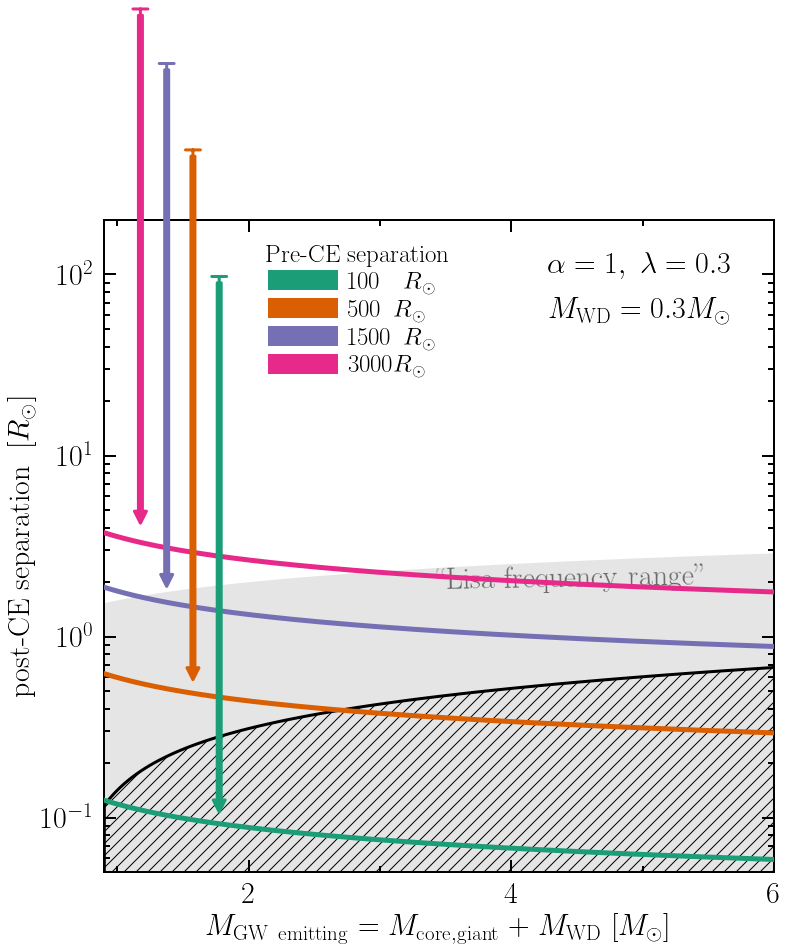

2.0 solMass
2.0


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


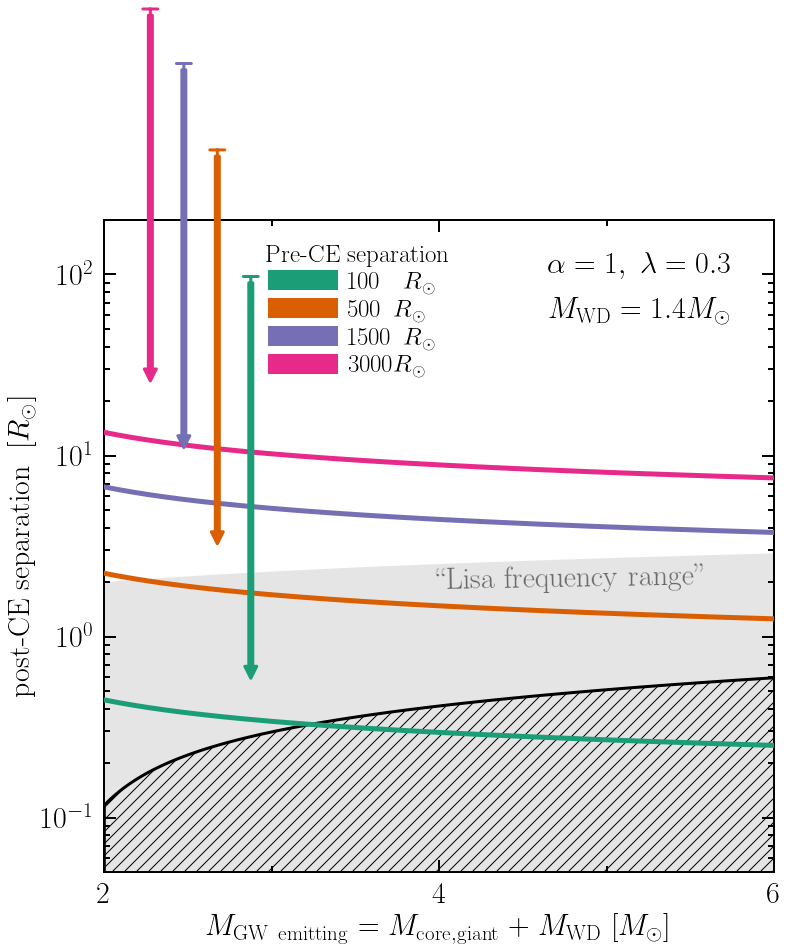

In [128]:
def Rrl(a, m1, m2):
    #RL1 for q = m1/m2
    q = m1/m2
    RL = a * 0.49 * q**(2./3) *(0.6 * q**(2./3) +np.log(1 + q**(1./3)) )**-1
    return RL

def Rcore_Hurley(M):
    """ calculate He core radii at TAMS following an approximation from Hurley"""
    R_HE = 0.2391*M**4.6/(M**4 + 0.162 * M**2 + 0.0065)
    return R_HE
    
def aLISA(mass):
    min_freq = 1e-4 *u.s**-1
    mass = mass.to(u.kg)
    a = pow(const.G * mass * (np.pi * min_freq)**-2, 1./3. )
    return a.to(u.Rsun)

def aLISAexit(mass):
    min_freq = 1e-1 *u.s**-1
    mass = mass.to(u.kg)
    a = pow(const.G * mass * (np.pi * min_freq)**-2, 1./3. )
    return a.to(u.Rsun)

def afinal(Mdcore = 1*u.Msun, Mdenv= 1*u.Msun, Mcomp= 1*u.Msun, a_ent= 1*u.Rsun, alpha=1.0, Lambda= 0.2):
    ## Mathieu: based on Fig. 1 in de Marco et al. 2011, lambda=0.2-0.3 is more realistic.
    Mdon = Mdcore + Mdenv
    Rrld = Rrl(a_ent, Mdon, Mcomp)
    # print('Rrld', Rrld)
    afinal = (Mdcore*Mcomp)/2 * ( (Mdon*Mdenv)/(alpha*Lambda*Rrld) + (Mdon*Mcomp)/(2*a_ent) )**-1
    return afinal

def plot_afinal_Mgw(companion_mass = 0.3, alpha=1.0):
    fig, ax = plt.subplots(figsize=(12,12))
   
    core_masses = np.arange(0.6, 10, 0.005)*u.Msun #Donor core masses
    # Mathieu: for core mass less than 0.6 the envelope mass from BSE is negative (guess those stars live longer than the universe!)

    plot_lines = []
    arrow = u'$\u2193$'
    
    linestyles = ['-', '--']
    ##############################
    # Loop over 2 companion masses 
    #companion_mass = The withe dwarf falling into the envelope
    #for c, companion_mass in enumerate([0.3, 1.4]*u.Msun):
    c = 0
    #GW emitting mass
    masses = core_masses + companion_mass
    print(min(masses))
    # Estimate of mass of envelope of giant 
    donor_envelope_masses = Menv(core_masses.value)*u.Msun # core_masses *2*u.Msun   #ballpack estimate

    ##############################
    ## Plot final separation as a function of GW emitting mass
    #a_enters = [10, 100, 500, 1500]#previous 10, 100, 200, 500, 1000 3000
    a_enters = [100, 500, 1500, 3000]#previous 10, 100, 200, 500, 1000 3000
    for i, a in enumerate(a_enters):
        # print(a)
        color = rainbow[i]
        ## alpha=1, Lambda=0.3
        afinals = afinal(Mdcore = core_masses, Mdenv = donor_envelope_masses, Mcomp= companion_mass, a_ent= a*u.Rsun, alpha=alpha, Lambda=0.3) 
        ax.plot(masses, afinals, ls=linestyles[c],lw=5, c = color, zorder=10 )

        ## Arrow showing drop
        if c == 0: # only do this for the first 2 lines
            point = 175-i*40
            mcore = core_masses[point] + companion_mass
            afin = afinal(Mdcore= mcore, Mdenv = donor_envelope_masses[point], Mcomp= companion_mass, a_ent= a*u.Rsun, alpha=alpha, Lambda=0.3) 
            ax.annotate("", xy = (mcore.value,afin.value ),  xytext = (mcore.value, a-(0.1*a) ), c=rainbow[i],
                        fontsize=25, arrowprops=dict(facecolor=color,color=color,lw=3), zorder=2000).set_clip_on(True)
            ax.annotate("", xy = (mcore.value,afin.value ),  xytext = (mcore.value, a ), color=rainbow[i],annotation_clip=True,
                        arrowprops=dict(facecolor=color,edgecolor=color,arrowstyle="|-|,widthA=0.75,widthB=0.",lw=3), zorder=2000)

    #######################
    # Estimate of He Core radii
    ax.fill_between(masses, y1=Rcore_Hurley(core_masses.value), y2 = 1e-3,
                     edgecolor="k", hatch='//',lw=3,facecolor="none", zorder=10 )


    ## for legend lines distinguishing lambda
    tabs = ['\phantom{00}','\phantom{0}', '\phantom{0}',"" ]
    for i, a in enumerate(a_enters):
        ax.plot(np.nan, np.nan, ls='-', lw=20, label=r"%.0f"%float(a)+tabs[i]+"$R_\odot$", c= rainbow[i])
    ax.plot(np.nan, np.nan, ls='-.',c='k',lw=3, label=r"$\alpha=1,\ \lambda=0.3$")
     
    
    ##################################
    ## Show region observable by LISA
    ax.fill_between(masses, aLISAexit(masses), aLISA(masses), facecolor='#808080',  alpha=0.2, zorder=0)
    ax.text(0.7, 0.45, r' ``Lisa frequency range"', fontsize = 30,color = '#696969', rotation=1,
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, zorder = 1)
    
    ##################################
    ## Annotate text
    ax.text(x=0.8, y=0.95, s=r"$\alpha=1,\ \lambda=0.3$", fontsize=30, transform=ax.transAxes,va="top",ha='center')
    # WD mass
    ax.text(0.8, 0.86, r'$M_\mathrm{WD}='+str(companion_mass.value)+r'M_\odot$', fontsize = 30, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
    ##################################
    ## Plot values
    ## Legend
    tabs = ['\phantom{00}','\phantom{0}', '\phantom{0}',"" ]
    for i, a in enumerate(a_enters):
        line = ax.plot(np.nan, np.nan, ls='-', lw=20, c= rainbow[i])
        plot_lines.append(line)
    legend1 = ax.legend([line[0] for line in plot_lines], [r"%.0f"%float(a_enters[i])+tabs[i]+"$R_\odot$" for i in range(len(a_enters))], 
                  fontsize = 25, bbox_to_anchor=(0.55,1.0),  bbox_transform=ax.transAxes, loc="upper right", 
                  ncol=1, columnspacing=0.5, labelspacing=0.15,frameon=False, 
                        title = "Pre-CE separation", title_fontsize=25)
    legend1._legend_box.align = "center"
    
    ############
    ## Limits
    #ax.set_ylim(3e-3,50)#1e2)
    ax.set_ylim(5e-2,2e2)
    #     ax.set_xlim(min(masses.value), max(masses.value))   
    print(min(masses.value))
    ax.set_xlim(min(masses.value), 6)   
    
    ############
    ## Labels and spines
    ax.set_xlabel(r'$M_\mathrm{GW\ emitting}$ = $M_\mathrm{core,giant}$ + $M_\mathrm{WD}$ [$M_\odot$]',size = 30)
    ax.set_ylabel(r'post-CE separation $\ [R_\odot]$',size = 30)
    plt.tick_params(axis='both', which='major', labelsize=25) #right side
    ax.set_yscale('log')
    
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
    ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    ## annotate the effect of changing $\alpha$    
    # plt.savefig('many_lambdas'+str(companion_mass.value).replace('.', 'd')+'.pdf', bbox_inches='tight')
    # plt.savefig('alphaLambda_separation.pdf', bbox_inches='tight')
    plt.show()
    

plot_afinal_Mgw(companion_mass = 0.3*u.Msun, alpha=1.0)
plot_afinal_Mgw(companion_mass = 1.4*u.Msun, alpha=1.0)

